In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os, sys
from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

stretch = AsinhStretch()

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

In [3]:
sys.path.append('.')

import autils

Load some test data

In [4]:
from astropy.utils.data import download_file

image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )
# image_data = fits.getdata(image_file)
with fits.open(image_file) as hdu: 
    image_data = hdu[0].data
    image_header = hdu[0].header
    image_wcs = WCS(image_header)

In [6]:
%matplotlib widget

In [ ]:
reload(autils.jupyter)

image_data_small = image_data[::10, ::10]

autils.jupyter.interactive_plot(image_data_small, wcs=image_wcs)

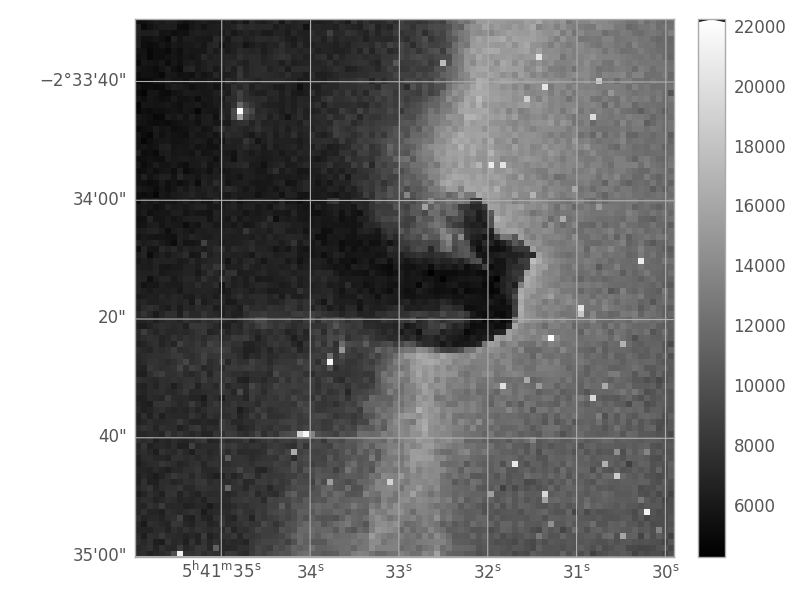

In [7]:
import autils.jupyter_fast


reload(autils.autils)
reload(autils)
reload(autils.jupyter_fast)

image_data_small = image_data[::10, ::10]

autils.jupyter_fast.interactive_plot(image_data_small, wcs=image_wcs)

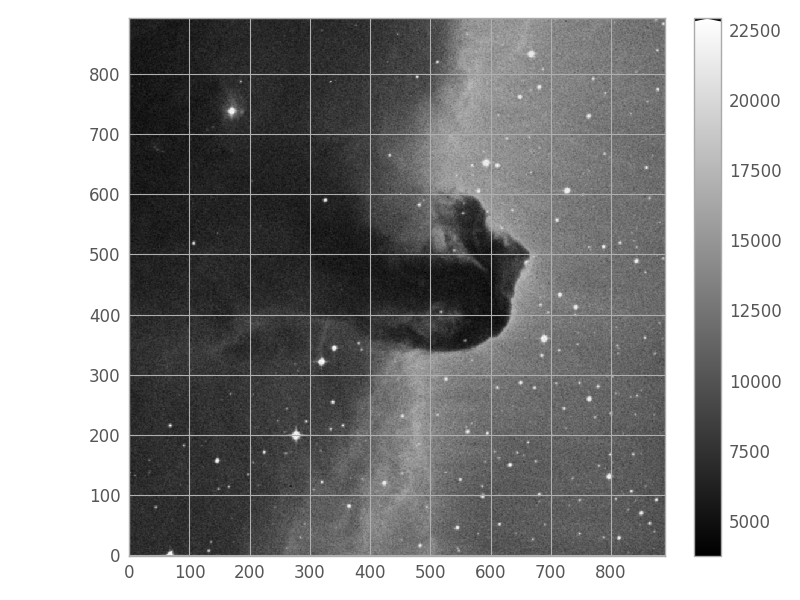

NameError: name 'args' is not defined

In [14]:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from astropy.visualization import ImageNormalize, LinearStretch, AsinhStretch, ZScaleInterval, HistEqStretch, LogStretch, PowerDistStretch, SinhStretch, SqrtStretch, SquaredStretch

import matplotlib.patches as patches

np.seterr(invalid='warn')

custom_css = """
<style>
    .widget-slider .slider {
        height: 16px; /* Thickness of the slider bar */
    }%matplotlib inline
%config InlineBackend.figure_format='retina'
    .widget-slider .noUi-handle {
        margin-top: 6px; /* Adjust to center the handle vertically */
    }
</style>
"""

display(HTML(custom_css))

def __create_triangle(x, y, l, h):
    triangle = patches.Polygon([[x, y+h], [x-l/2, y], [x+l/2, y]], 
                               closed=True, color='k')
    return triangle

def __reset_slider(slider, value): 
    slider.value = value

def __make_plot(data, 
            scale_method=LinearStretch, 
            scale_range='min max', 
            scale_slider=0, 
            colormap='grey', 
            show_grid=True, 
            coordinate='image', 
            wcs=None):
    data = np.asarray(data, dtype=np.float64)
    fig = plt.figure(figsize=[8, 6])
    # parse coordinate
    if coordinate=='world':
        ax = fig.add_subplot(111, projection=wcs)
        ax.coords[0].set_axislabel_visibility_rule('ticks')
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_axislabel_visibility_rule('ticks')
        ax.coords[1].set_ticks_visible(False)
    if coordinate=='image':
        ax = fig.add_subplot(111)
    else: 
        pass
    # parse scale_range
    if scale_range=='min max':
        vmin = np.min(data)
        vmax = np.max(data)
    elif scale_range=='zscale': 
        zscale_interval = ZScaleInterval()
        vmin, vmax = zscale_interval.get_limits(data)
    else: 
        pass
    # parse scale_slider
    offset = scale_slider*(vmax - vmin)
    vmax_shifted = vmax - offset
    vmin_shifted = vmin - offset
    # parse scale_method
    args = [data] if scale_method==HistEqStretch else []
    norm = ImageNormalize(stretch=scale_method(*args), 
                          vmin=vmin_shifted, vmax=vmax_shifted)
    # imshow
    im = ax.imshow(data, cmap=colormap, norm=norm)
    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # mark the upper and lower bound of the colorbar
    cbar.ax.add_patch(__create_triangle(0, np.min(data), 1, (vmax-vmin)/200))
    cbar.ax.add_patch(__create_triangle(1, np.min(data), 1, (vmax-vmin)/200))
    cbar.ax.add_patch(__create_triangle(0, np.max(data), 1, (vmin-vmax)/200))
    cbar.ax.add_patch(__create_triangle(1, np.max(data), 1, (vmin-vmax)/200))
    # parse show_grid
    ax.grid(show_grid)
    # show image
    fig.tight_layout()
    # plt.show()
    return fig, ax, im, cbar

def __update_plot(change):
    # Update scale method
    norm = ImageNormalize(stretch=scale_method(*args), 
                          vmin=vmin_shifted, vmax=vmax_shifted)
    im.set_norm(norm)
    # Update colormap
    im.set_cmap(colormap.value)
    # Update color limits
    im.set_clim(vmin_shifted, vmax_shifted)
    # Update colorbar
    cbar.update_normal(im)
    fig.canvas.draw_idle()  # Efficient redraw without full replot
    

# def interactive_plot(data, wcs=None):
data = image_data
wcs = image_wcs

scale_method = widgets.ToggleButtons(
    options=[('asinh', AsinhStretch), 
                ('histogram', HistEqStretch), 
                ('linear', LinearStretch), 
                ('log', LogStretch), 
                ('power dist', PowerDistStretch), 
                ('sinh', SinhStretch), 
                ('sqrt', SqrtStretch), 
                ('squared', SquaredStretch)],
    value=LinearStretch, 
    layout=Layout(width='80%', height='33px'), 
    description='',
    disabled=False, 
    style={'button_width': '11.8%'}
)

scale_range = widgets.ToggleButtons(
    options=['min max', 'zscale'],
    value='min max',
    layout=Layout(width='20%', height='33px'), 
    description='',
    disabled=False, 
    style={'button_width': '47%'}
)

scale_slider = widgets.FloatSlider(
    value=0,
    min=-1,
    max=1,
    step=0.005,
    description='',
    continuous_update=True,
    readout=False,
    layout=Layout(width='50%')
)

reset_button = widgets.Button(
    description='reset',
    layout=Layout(width='10%')
)
reset_button.on_click(lambda b: __reset_slider(scale_slider, 0))

colormap = widgets.Dropdown(
    options=['gist_heat', 'grey', 'seismic'],
    value='grey',
    description='',
    disabled=False,
    layout=Layout(width='10%'), 
)

show_grid = widgets.ToggleButton(
    value=True,
    description='grid',
    disabled=False,
    button_style='',
    tooltip='Description',
    icon='check',
    layout=Layout(width='10%'), 
)

no_wcs = wcs is None
coordinate = widgets.ToggleButtons(
    options=['image', 'world'],
    value='world',
    layout=Layout(width='20%', height='33px'), 
    description='',
    disabled=no_wcs, 
    style={'button_width': '47%'}
)

# out = widgets.interactive_output(__make_plot, 
#                                 {'data':  widgets.fixed(data), 
#                                 'scale_method': scale_method, 
#                                 'scale_range': scale_range, 
#                                 'scale_slider': scale_slider, 
#                                 'colormap': colormap, 
#                                 'show_grid': show_grid,
#                                 'coordinate': coordinate, 
#                                 'wcs':  widgets.fixed(wcs)})

# display(ui, out)

# Initialize plot
fig, ax, im, cbar = __make_plot(data)

# Link widgets to update function
scale_method.observe(__update_plot, names='value')
scale_range.observe(__update_plot, names='value')
scale_slider.observe(__update_plot, names='value')
colormap.observe(__update_plot, names='value')
show_grid.observe(__update_plot, names='value')
coordinate.observe(__update_plot, names='value')

ui1 = widgets.HBox([scale_method, scale_range])
ui2 = widgets.HBox([reset_button, scale_slider, 
                    colormap, show_grid, coordinate])
ui = widgets.VBox([ui1, ui2])

display(ui)

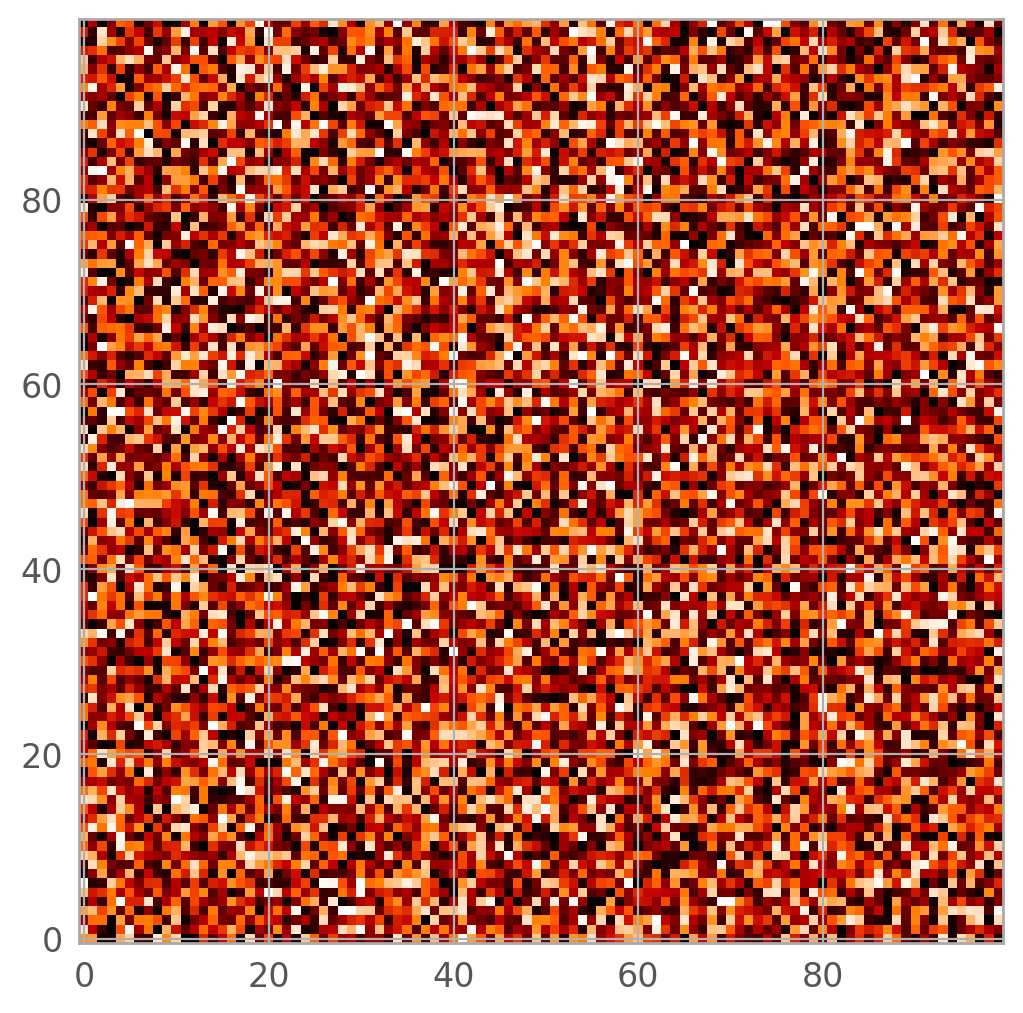

In [87]:
%matplotlib inline

plt.imshow(np.random.rand(100, 100))
plt.show()